### Import modules

In [1]:
import os
import pickle

from os.path import isdir, join
from pathlib import Path

import librosa
import librosa.display

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, LSTM, GRU, Bidirectional
from keras.utils import to_categorical

from sklearn.model_selection import KFold, train_test_split

/home/seongjinpark/.conda/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/seongjinpark/.conda/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/seongjinpark/.conda/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/seongjinpark/.conda/envs/pyt

In [2]:
tf.test.is_gpu_available()

True

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Check the location of WAV files

In [4]:
!ls ../audio/wavs

S02_Almost-All-Colleges.wav	     S19_Military-Personnel-Are.wav
S02_A-Monstrous-Shadow.wav	     S19_Nothing-Has-Been.wav
S02_An-Adult-Male.wav		     S19_Of-Course-Dear.wav
S02_Any-Organism-That.wav	     S19_Only-The-Most.wav
S02_Are-You-Looking.wav		     S19_Pam-Gives-Driving.wav
S02_Before-Thursdays-Exam.wav	     S19_Ralph-Prepared-Red.wav
S02_Carl-Lives-In.wav		     S19_She-Had-Your.wav
S02_Combine-All-The.wav		     S19_Steve-Collects-Rare.wav
S02_Continental-Drift-Is.wav	     S19_The-Moisture-In.wav
S02_Did-Shawn-Catch.wav		     S19_The-Small-Boy.wav
S02_Dont-Ask-Me.wav		     S19_The-Surplus-Shoes.wav
S02_Gently-Place-Jims.wav	     S19_The-Tooth-Fairy.wav
S02_George-And-Tom.wav		     S19_They-All-Like.wav
S02_Gregory-And-Tom.wav		     S19_They-Enjoy-It.wav
S02_He-Ate-Four.wav		     S19_They-Were-Already.wav
S02_He-Shrugged-Casually.wav	     S19_Those-Answers-Will.wav
S02_How-Oily-Do.wav		     S19_Thus-Technical-Efficiency.wav
S02_How-Permanent-Are.wav	     S19_Too-Much-Curiosity.wav

### Check wav files

In [5]:
audio_path = '../audio/wavs/'
print(os.listdir(audio_path)[:10])

['S09_He-Ate-Four.wav', 'S26_Those-Answers-Will.wav', 'S28_Try-To-Recall.wav', 'S03_Thus-Technical-Efficiency.wav', 'S25_Try-To-Recall.wav', 'S02_A-Monstrous-Shadow.wav', 'S21_A-Monstrous-Shadow.wav', 'S04_The-Small-Boy.wav', 'S28_Gently-Place-Jims.wav', 'S21_Military-Personnel-Are.wav']


### Extract mel-spectrogram and mfcc features

In [6]:
wav2idx = {}
melspec_dict = {}
mfcc_dict = {}

wav_names = [wav for wav in os.listdir(audio_path) if wav.endswith("wav")]

samples = 132300
max_len = 0

for i, w in enumerate(wav_names):
    wav2idx[w] = i
    wav_path = audio_path + w
    
    y, sr = librosa.load(wav_path) 
    
#     sample = sr * 5
    
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)

    if len(y) > samples: # long enough
        y = y[0:0+samples]

    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    
    
    mel_data = librosa.feature.melspectrogram(y = y, sr= sr)
    mfcc_data = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 13)
    mfcc_delta = librosa.feature.delta(mfcc_data)
    mfcc_delta2 = librosa.feature.delta(mfcc_data, order = 2)

    mfcc = np.vstack((mfcc_data, mfcc_delta, mfcc_delta2))
#     if (np.shape(mel_data)[1] > max_len):
#         max_len = np.shape(mel_data)[1] 
    
    melspec_dict[i] = mel_data
    mfcc_dict[i] = mfcc

### Check the shape

In [7]:
print(max_len)
print(sr * 5)
for i in list(melspec_dict.keys())[:10]:
    print(melspec_dict[i].shape)

0
110250
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)
(128, 259)


In [8]:
with open("../data/perception_results/comp_data.csv", "r") as f:
    data = f.readlines()

In [9]:
X = []
Y = []
X_wav = []

zeros = np.zeros(128)
for i in range(1, len(data)):
    line = data[i].rstrip()
    
    accented, stim, wav_name = line.split(",")
    wav_idx = wav2idx[wav_name]
    X_wav.append(wav_idx)
    
#     x = np.zeros(shape = (128, max_len))
    # x_data = np.vstack((melspec_dict[wav_idx],mfcc_dict[wav_idx]))
    x_data = mfcc_dict[wav_idx]

#     print(np.shape(x), np.shape(x_data))
    
#     for i in range(0, np.shape(x_data)[0]):
#         for j in range(0, np.shape(x_data)[1]):
#             x[i][j] = x_data[i][j]
    
    X.append(x_data)
    Y.append(int(accented)-1)

print(np.shape(X))
print(np.shape(Y))
print()

(11100, 39, 259)
(11100,)



In [10]:
kf = KFold(n_splits = 10)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


In [11]:
# reshape
X = np.array(X)
Y = np.array(Y)
X_wav = np.array(X_wav)
print(np.shape(X))
print(np.shape(X_wav))


(11100, 39, 259)
(11100,)


In [12]:
for train_index, test_index in kf.split(X):
    print("TRAIN: ", X_wav[train_index])
    print("TRAIN: ", Y[test_index])

TRAIN:  [510 467 571 ... 175 139  69]
TRAIN:  [1 5 5 ... 5 2 5]
TRAIN:  [404 454 554 ... 175 139  69]
TRAIN:  [5 5 5 ... 2 3 2]
TRAIN:  [404 454 554 ... 175 139  69]
TRAIN:  [3 3 4 ... 5 5 4]
TRAIN:  [404 454 554 ... 175 139  69]
TRAIN:  [2 5 5 ... 5 1 1]
TRAIN:  [404 454 554 ... 175 139  69]
TRAIN:  [1 2 1 ... 5 5 5]
TRAIN:  [404 454 554 ... 175 139  69]
TRAIN:  [5 4 5 ... 1 2 5]
TRAIN:  [404 454 554 ... 175 139  69]
TRAIN:  [5 5 5 ... 2 2 0]
TRAIN:  [404 454 554 ... 175 139  69]
TRAIN:  [0 4 2 ... 2 5 5]
TRAIN:  [404 454 554 ... 175 139  69]
TRAIN:  [5 4 4 ... 4 3 3]
TRAIN:  [404 454 554 ... 117 264  63]
TRAIN:  [3 3 4 ... 4 2 3]


In [13]:
# hyperparameters
lr = 0.001
batch_size = 64
drop_out_rate = 0.25
num_dense_unit = 256
num_epochs = 50

num_mel = np.shape(X)[1]
max_time = np.shape(X)[2]

In [14]:
input_shape = (num_mel, max_time)

model = Sequential()

model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (num_mel, max_time)))
model.add(Bidirectional(LSTM(512)))
model.add(Dropout(drop_out_rate))
model.add(Dense(num_dense_unit))
model.add(Dense(128))
model.add(Dense(1, activation='linear'))

# use adam optimizer
adam = keras.optimizers.Adam(lr = lr)

# compile the model
model.compile(optimizer=adam, loss="mse", metrics=["mse"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 39, 1024)          3162112   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,753,089
Trainable params: 9,753,089
Non-trainable params: 0
____________________________________________

In [15]:
from datetime import datetime
logdir = "logs/scalars/CV_COMP" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [16]:
CV_mse = []
CV_histories = []
CV_prediction = []

In [ ]:
num_epochs = 40

cv_idx = 1
for train_index, test_index in kf.split(X):
    model_name = "../data/CV_comp_rnn_mfcc_40_CV%d.h5" % (cv_idx)
#     model.load_weights(model_name)
    X_train, X_test = X[train_index], X[test_index]
    X_train_wav, X_test_wav = X_wav[train_index], X_wav[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = False,
                       class_weight = None, verbose = 1, validation_data = (X_test, y_test), 
                       callbacks = [tensorboard_callback])
    CV_histories.append(history)
            
    model.save(model_name)
    
    scores = model.evaluate(X_test, y_test, verbose=0)
    CV_mse.append(scores[1])
    y_prediction = model.predict(X_test)
    
    for i in range(len(y_test)):
        result = "%d\t%s\t%d\t%f\n" % (cv_idx, wav_names[X_test_wav[i]], y_test[i], y_prediction[i][0])
#         print(result)
        CV_prediction.append(result)
    
    cv_idx += 1

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("MSE: %.5f" % (scores[1]))

In [ ]:
for i, mse in enumerate(CV_mse[-10:]):
    print(i + 1, mse)
    

In [ ]:
with open("../results/comp_mfcc_10CV.txt", "w") as output:
    for prediction in CV_prediction:
        output.write(prediction)

### Plot the training process

In [ ]:
# summarize history for loss

for history in CV_histories[-10:]:
    plt.plot(history.history['loss'])
    
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], loc='upper left')
plt.show()

The result looks like the model gets stable after 20 epochs

### Train and Test the model with Mel-Spectrogram

In [23]:
X_mel = []
X_wav = []
Y = []

zeros = np.zeros(128)
for i in range(1, len(data)):
    line = data[i].rstrip()
    
    accented, stim, wav_name = line.split(",")
    wav_idx = wav2idx[wav_name]
    X_wav.append(wav_idx)

    x_data = melspec_dict[wav_idx]

    X_mel.append(x_data)
    Y.append(int(accented)-1)

print(np.shape(X_mel))
print(np.shape(Y))

(10806, 128, 259)
(10806,)


In [24]:
# reshape
X_mel = np.array(X_mel)
X_wav = np.array(X_wav)
Y = np.array(Y)

# X_train = X_train.reshape(X_train.shape[0], max_time, num_mel, 1)
# X_test = X_test.reshape(X_test.shape[0], max_time, num_mel, 1)



print(np.shape(X_mel))
print(np.shape(Y))

(10806, 128, 259)
(10806,)


In [25]:
for train_index, test_index in kf.split(X):
    print("TRAIN: ", X_mel[train_index])
    print("TRAIN: ", X_wav[train_index])
    print("TRAIN: ", Y[test_index])

TRAIN:  [[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+

TRAIN:  [[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+

TRAIN:  [223 599 565 ...  15 577  71]
TRAIN:  [5 0 1 ... 2 2 2]
TRAIN:  [[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e

In [26]:
# hyperparameters
lr = 0.001
batch_size = 64
drop_out_rate = 0.25
num_dense_unit = 256
num_epochs = 50

num_melspec = np.shape(X_mel)[1]
max_time = np.shape(X_mel)[2]

In [27]:
input_shape = (num_melspec, max_time)

model_mel = Sequential()

model_mel.add(Bidirectional(LSTM(512, return_sequences=True), input_shape = (num_melspec, max_time)))
model_mel.add(Bidirectional(LSTM(512)))
model_mel.add(Dropout(drop_out_rate))
model_mel.add(Dense(num_dense_unit))
model_mel.add(Dense(128))
model_mel.add(Dense(1, activation='linear'))

# use adam optimizer
adam = keras.optimizers.Adam(lr = lr)

# compile the model
model_mel.compile(optimizer=adam, loss="mse", metrics=["mse"])

model_mel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128, 1024)         3162112   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 9,753,089
Trainable params: 9,753,089
Non-trainable params: 0
_________________________________________________________________


In [28]:
from datetime import datetime
logdir = "logs/scalars/melspec_CV_ACC" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
CV_mel_mse = []
CV_mel_histories = []
CV_mel_prediction = []

In [30]:
num_epochs = 40

cv_idx = 1
for train_index, test_index in kf.split(X_mel):
    model_name = "../data/CV_ACC_mel_40_CV%d.h5" % (cv_idx)
#     model.load_weights(model_name)
    X_train, X_test = X_mel[train_index], X_mel[test_index]
    X_train_wav, X_test_wav = X_wav[train_index], X_wav[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    history = model_mel.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, shuffle = False,
                       class_weight = None, verbose = 1, validation_data = (X_test, y_test), 
                       callbacks = [tensorboard_callback])
    CV_mel_histories.append(history)
            
    model_mel.save(model_name)
    
    scores = model_mel.evaluate(X_test, y_test, verbose=0)
    CV_mel_mse.append(scores[1])
    y_prediction = model_mel.predict(X_test)
    
    for i in range(len(y_test)):
        result = "%d\t%s\t%d\t%f\n" % (cv_idx, wav_names[X_test_wav[i]], y_test[i], y_prediction[i][0])
#         print(result)
        CV_mel_prediction.append(result)
    
    cv_idx += 1

Train on 9725 samples, validate on 1081 samples
Epoch 1/40
9725/9725 [==============================] - 73s 7ms/step - loss: 2.5238 - mean_squared_error: 2.5238 - val_loss: 3.6068 - val_mean_squared_error: 3.6068
Epoch 2/40
9725/9725 [==============================] - 71s 7ms/step - loss: 2.1608 - mean_squared_error: 2.1608 - val_loss: 3.2893 - val_mean_squared_error: 3.2893
Epoch 3/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.7719 - mean_squared_error: 1.7719 - val_loss: 2.1613 - val_mean_squared_error: 2.1613
Epoch 4/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.6159 - mean_squared_error: 1.6159 - val_loss: 1.7432 - val_mean_squared_error: 1.7432
Epoch 5/40
9725/9725 [==============================] - 70s 7ms/step - loss: 1.5607 - mean_squared_error: 1.5607 - val_loss: 1.5840 - val_mean_squared_error: 1.5840
Epoch 6/40
9725/9725 [==============================] - 72s 7ms/step - loss: 1.5116 - mean_squared_error: 1.5116 - val_loss: 1.

Epoch 10/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.3404 - mean_squared_error: 1.3404 - val_loss: 1.0992 - val_mean_squared_error: 1.0992
Epoch 11/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.3489 - mean_squared_error: 1.3489 - val_loss: 1.0926 - val_mean_squared_error: 1.0926
Epoch 12/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.3483 - mean_squared_error: 1.3483 - val_loss: 1.1188 - val_mean_squared_error: 1.1188
Epoch 13/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.3416 - mean_squared_error: 1.3416 - val_loss: 1.1124 - val_mean_squared_error: 1.1124
Epoch 14/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.3409 - mean_squared_error: 1.3409 - val_loss: 1.1213 - val_mean_squared_error: 1.1213
Epoch 15/40
9725/9725 [==============================] - 70s 7ms/step - loss: 1.3356 - mean_squared_error: 1.3356 - val_loss: 1.1558 - val_mean_squared_error: 1.1558
Epoc

9725/9725 [==============================] - 71s 7ms/step - loss: 1.2007 - mean_squared_error: 1.2007 - val_loss: 2.5563 - val_mean_squared_error: 2.5563
Epoch 29/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.2068 - mean_squared_error: 1.2068 - val_loss: 2.5096 - val_mean_squared_error: 2.5096
Epoch 30/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.2051 - mean_squared_error: 1.2051 - val_loss: 2.6466 - val_mean_squared_error: 2.6466
Epoch 31/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.2065 - mean_squared_error: 1.2065 - val_loss: 2.5385 - val_mean_squared_error: 2.5385
Epoch 32/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.2098 - mean_squared_error: 1.2098 - val_loss: 2.5317 - val_mean_squared_error: 2.5317
Epoch 33/40
9725/9725 [==============================] - 71s 7ms/step - loss: 1.2038 - mean_squared_error: 1.2038 - val_loss: 2.6308 - val_mean_squared_error: 2.6308
Epoch 34/40
9725

Epoch 6/40
9726/9726 [==============================] - 71s 7ms/step - loss: 1.3044 - mean_squared_error: 1.3044 - val_loss: 1.0450 - val_mean_squared_error: 1.0450
Epoch 7/40
9726/9726 [==============================] - 71s 7ms/step - loss: 1.2995 - mean_squared_error: 1.2995 - val_loss: 1.0479 - val_mean_squared_error: 1.0479
Epoch 8/40
9726/9726 [==============================] - 71s 7ms/step - loss: 1.2960 - mean_squared_error: 1.2960 - val_loss: 1.0495 - val_mean_squared_error: 1.0495
Epoch 9/40
9726/9726 [==============================] - 72s 7ms/step - loss: 1.2913 - mean_squared_error: 1.2913 - val_loss: 1.0524 - val_mean_squared_error: 1.0524
Epoch 10/40
9726/9726 [==============================] - 72s 7ms/step - loss: 1.2959 - mean_squared_error: 1.2959 - val_loss: 1.0560 - val_mean_squared_error: 1.0560
Epoch 11/40
9726/9726 [==============================] - 71s 7ms/step - loss: 1.2989 - mean_squared_error: 1.2989 - val_loss: 1.0578 - val_mean_squared_error: 1.0578
Epoch 12

9726/9726 [==============================] - 71s 7ms/step - loss: 1.2800 - mean_squared_error: 1.2800 - val_loss: 1.3561 - val_mean_squared_error: 1.3561
Epoch 25/40
9726/9726 [==============================] - 71s 7ms/step - loss: 1.2736 - mean_squared_error: 1.2736 - val_loss: 1.4088 - val_mean_squared_error: 1.4088
Epoch 26/40
9726/9726 [==============================] - 71s 7ms/step - loss: 1.2754 - mean_squared_error: 1.2754 - val_loss: 1.3826 - val_mean_squared_error: 1.3826
Epoch 27/40
9726/9726 [==============================] - 71s 7ms/step - loss: 1.2725 - mean_squared_error: 1.2725 - val_loss: 1.4083 - val_mean_squared_error: 1.4083
Epoch 28/40
9726/9726 [==============================] - 70s 7ms/step - loss: 1.2775 - mean_squared_error: 1.2775 - val_loss: 1.4074 - val_mean_squared_error: 1.4074
Epoch 29/40
9726/9726 [==============================] - 71s 7ms/step - loss: 1.2763 - mean_squared_error: 1.2763 - val_loss: 1.3878 - val_mean_squared_error: 1.3878
Epoch 30/40
9726

In [31]:
for i, mse in enumerate(CV_mse[-10:]):
    print(i + 1, mse)

1 1.459484366081469
2 1.119681463651807
3 1.2086396092733336
4 2.401153661496765
5 1.3314205574614377
6 1.447696704096975
7 1.1030245114255834
8 1.2911398031093455
9 1.5589563369750976
10 2.038569023874071


In [32]:
with open("../results/accented_mel_10CV.txt", "w") as output:
    for prediction in CV_mel_prediction:
        output.write(prediction)

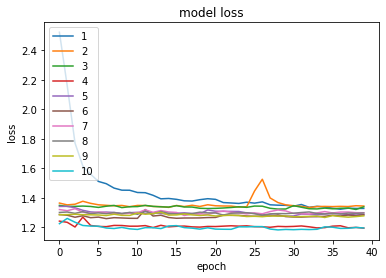

In [33]:
# summarize history for loss

for history in CV_mel_histories[-10:]:
    plt.plot(history.history['loss'])
    
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], loc='upper left')
plt.show()